# ============================================================
# IMPORTS AND SETUP
# ============================================================

In [1]:
# ============================================================
# FINAL PROTOBUF FIX FOR PYTHON 3.11 (Colab/Kaggle safe)
# ============================================================

!pip install --upgrade --quiet protobuf==4.25.3

# Optional: Disable GPU (no warnings)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Reduce unnecessary TF logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("Protobuf fixed to 4.25.3 — Now restart runtime.")




import os, time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, silhouette_score
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Try UMAP
try:
    import umap
    UMAP_OK = True
except:
    print("UMAP not available – continuing without UMAP.")
    UMAP_OK = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have proto

2025-12-02 03:44:48.196638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764647088.387851      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764647088.441405      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



# ============================================================
# CONFIGURATION
# ============================================================

In [2]:

DATA_PATH = "/kaggle/input/orgial-dataset-arsenic/Original"    # <<< CHANGE THIS
IMAGE_SIZE = 128
BATCH = 32
PRETEXT_EPOCHS = 100
LR = 0.001                       # <<< Learning Rate Updated
BT_LAMBDA = 0.005
PROJ_DIM = 512
LP_EPOCHS = 40
FINETUNE_EPOCHS = 15

torch.manual_seed(42)
np.random.seed(42)


In [3]:
import os
from torchvision import datasets

print("Folders inside DATA_PATH:", os.listdir(DATA_PATH))

full_tmp = datasets.ImageFolder(DATA_PATH)
print("Classes detected by ImageFolder:", full_tmp.classes)

Folders inside DATA_PATH: ['infacted', 'not_infacted']
Classes detected by ImageFolder: ['infacted', 'not_infacted']


# ============================================================
# DATA AUGMENTATION (BARLOW TWINS)
# ============================================================


In [4]:
train_aug = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=11),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE / 0.875)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class TwoCropTransform:
    def __init__(self, t): self.t = t
    def __call__(self, x): return self.t(x), self.t(x)


# ============================================================
# 80/20 TRAIN–TEST SPLIT
# ============================================================

In [5]:
# SPLIT
from torchvision import datasets

full = datasets.ImageFolder(DATA_PATH)

# FIX class names (your folder names are: infacted, not_infacted)
full.class_to_idx = {"infected": 0, "non_infected": 1}
full.classes = ["infected", "non_infected"]

print("Loaded dataset with classes:", full.classes)
print("Total images:", len(full))


n = len(full)
n_train = int(0.8 * n)
n_test = n - n_train

train_ds, test_ds = random_split(full, [n_train, n_test])

# IMPORTANT: Restore TwoCropTransform for SSL
train_ds.dataset.transform = TwoCropTransform(train_aug)

# Normal transform for test
test_ds.dataset.transform = test_tf

# LOADERS
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

Loaded dataset with classes: ['infected', 'non_infected']
Total images: 1287



# ============================================================
# GOOGLENET BACKBONE + PROJECTOR
# ============================================================

In [6]:
class GoogLeNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        g = models.googlenet(weights=None, aux_logits=False)
        self.features = nn.Sequential(*list(g.children())[:-1])
        self.out_dim = 1024
    def forward(self, x):
        return torch.flatten(self.features(x), 1)

class Projector(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.BatchNorm1d(in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, proj_dim)
        )
    def forward(self, x): return self.net(x)

backbone = GoogLeNetBackbone()
projector = Projector(backbone.out_dim, PROJ_DIM)

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


# ============================================================
# BARLOW TWINS LOSS
# ============================================================

In [7]:
def barlow_twins_loss(z1, z2, lambd=BT_LAMBDA):
    N, D = z1.size()
    z1 = (z1 - z1.mean(0)) / (z1.std(0) + 1e-9)
    z2 = (z2 - z2.mean(0)) / (z2.std(0) + 1e-9)
    c = (z1.T @ z2) / N
    on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
    off_diag = c.flatten()[~torch.eye(D, dtype=bool)].pow_(2).sum()
    return on_diag + lambd * off_diag

optimizer = torch.optim.SGD(
    list(backbone.parameters()) + list(projector.parameters()),
    lr=LR, momentum=0.9
)

# ============================================================
# PRETEXT TRAINING (BARLOW TWINS)
# ============================================================

In [8]:
# ============================================================
# FULL FIXED PRETEXT SECTION — SSL loader, projector, loss, training
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------- SETTINGS (adjust if needed) -------------
PROJ_DIM = 512           # <-- important: use >= 128 typically; 512 is safe
LR_PRETEXT = 0.001
BT_LAMBDA = 0.005
# BATCH, PRETEXT_EPOCHS, train_ds, train_aug, test_tf, TwoCropTransform,
# backbone should already be defined in your notebook environment.

device = torch.device("cpu")   # change to 'cuda' if you have GPU and moved model to cuda

# ------------- Ensure base dataset returns PIL images -------------
# ImageFolder/Subset might have transforms applied earlier; remove them so we get PIL images
try:
    full.transform = None
except Exception:
    pass
try:
    train_ds.dataset.transform = None
except Exception:
    pass

# ------------- SSLSubset wrapper that returns two crops -------------
class SSLSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]        # img should be PIL image
        x1, x2 = self.transform(img)         # TwoCropTransform returns two PIL->Tensor views
        return (x1.to(device), x2.to(device)), label

# Create SSL dataset + dataloader
train_ds_ssl = SSLSubset(train_ds, TwoCropTransform(train_aug))
train_loader = DataLoader(train_ds_ssl, batch_size=BATCH, shuffle=True)

# ------------- Re-create projector and optimizer (safe PROJ_DIM) -------------
class Projector(nn.Module):
    def __init__(self, in_dim, proj_dim=PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.BatchNorm1d(in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, proj_dim)
        )
    def forward(self, x): return self.net(x)

# instantiate projector and move to device
projector = Projector(backbone.out_dim, PROJ_DIM).to(device)
backbone = backbone.to(device)

# re-create optimizer for backbone + projector (LR = 0.001)
optimizer = torch.optim.SGD(
    list(backbone.parameters()) + list(projector.parameters()),
    lr=LR_PRETEXT, momentum=0.9
)

# ------------- Robust Barlow Twins loss (safe for D==1 or batch_size==1) -------------
def barlow_twins_loss(z1, z2, lambd=BT_LAMBDA):
    # ensure 2D tensors (N, D)
    if z1.dim() == 1:
        z1 = z1.unsqueeze(0)
    if z2.dim() == 1:
        z2 = z2.unsqueeze(0)

    N, D = z1.size()

    # normalize per-dimension (batch-wise)
    z1_norm = (z1 - z1.mean(0)) / (z1.std(0) + 1e-9)
    z2_norm = (z2 - z2.mean(0)) / (z2.std(0) + 1e-9)

    # cross-correlation matrix (D x D)
    c = (z1_norm.T @ z2_norm) / N   # shape: (D, D)

    # on-diagonal: (c_ii - 1)^2
    on_diag = (torch.diagonal(c) - 1).pow(2).sum()

    # off-diagonal: sum of squares of off-diagonal elements
    if D == 1:
        off_diag = torch.tensor(0.0, device=c.device)
    else:
        # create boolean mask for off-diagonal
        eye = torch.eye(D, dtype=torch.bool, device=c.device)
        off_diag = c.flatten()[~eye.flatten()].pow(2).sum()

    return on_diag + lambd * off_diag

# ------------- Pretext training loop -------------
print("\n=== Pretext Training: Barlow Twins (LR = {}) ===".format(LR_PRETEXT))
pretext_losses = []

for epoch in range(1, PRETEXT_EPOCHS + 1):
    running_loss = 0.0
    backbone.train()
    projector.train()

    for (x1, x2), _ in tqdm(train_loader, desc=f"Pretext Epoch {epoch}/{PRETEXT_EPOCHS}"):
        # x1,x2 are tensors on device
        # forward through backbone+projector
        z1 = projector(backbone(x1))
        z2 = projector(backbone(x2))

        loss = barlow_twins_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg = running_loss / (len(train_loader) if len(train_loader)>0 else 1)
    pretext_losses.append(avg)
    print(f"Epoch {epoch} | Loss: {avg:.6f}")

# ------------- Save loss curve and encoder -------------
plt.plot(pretext_losses)
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("Barlow Twins Pretext Loss (LR={})".format(LR_PRETEXT))
plt.savefig("pretext_loss.png")
plt.close()

torch.save(backbone.state_dict(), "barlow_encoder.pth")
print("Saved encoder: barlow_encoder.pth")



=== Pretext Training: Barlow Twins (LR = 0.001) ===


Pretext Epoch 1/100: 100%|██████████| 33/33 [04:11<00:00,  7.63s/it]


Epoch 1 | Loss: 569.075987


Pretext Epoch 2/100: 100%|██████████| 33/33 [04:03<00:00,  7.37s/it]


Epoch 2 | Loss: 497.414982


Pretext Epoch 3/100: 100%|██████████| 33/33 [04:00<00:00,  7.30s/it]


Epoch 3 | Loss: 434.242358


Pretext Epoch 4/100: 100%|██████████| 33/33 [03:59<00:00,  7.24s/it]


Epoch 4 | Loss: 429.760520


Pretext Epoch 5/100: 100%|██████████| 33/33 [04:01<00:00,  7.33s/it]


Epoch 5 | Loss: 401.373788


Pretext Epoch 6/100: 100%|██████████| 33/33 [04:03<00:00,  7.39s/it]


Epoch 6 | Loss: 387.401720


Pretext Epoch 7/100: 100%|██████████| 33/33 [04:03<00:00,  7.37s/it]


Epoch 7 | Loss: 357.363565


Pretext Epoch 8/100: 100%|██████████| 33/33 [04:01<00:00,  7.32s/it]


Epoch 8 | Loss: 351.367707


Pretext Epoch 9/100: 100%|██████████| 33/33 [04:00<00:00,  7.30s/it]


Epoch 9 | Loss: 349.011178


Pretext Epoch 10/100: 100%|██████████| 33/33 [04:03<00:00,  7.39s/it]


Epoch 10 | Loss: 347.429727


Pretext Epoch 11/100: 100%|██████████| 33/33 [04:03<00:00,  7.37s/it]


Epoch 11 | Loss: 358.937214


Pretext Epoch 12/100: 100%|██████████| 33/33 [03:46<00:00,  6.87s/it]


Epoch 12 | Loss: 361.675104


Pretext Epoch 13/100: 100%|██████████| 33/33 [03:39<00:00,  6.66s/it]


Epoch 13 | Loss: 355.733131


Pretext Epoch 14/100: 100%|██████████| 33/33 [03:41<00:00,  6.72s/it]


Epoch 14 | Loss: 337.765797


Pretext Epoch 15/100: 100%|██████████| 33/33 [03:50<00:00,  6.98s/it]


Epoch 15 | Loss: 369.102079


Pretext Epoch 16/100: 100%|██████████| 33/33 [03:51<00:00,  7.01s/it]


Epoch 16 | Loss: 329.433776


Pretext Epoch 17/100: 100%|██████████| 33/33 [03:41<00:00,  6.70s/it]


Epoch 17 | Loss: 321.362538


Pretext Epoch 18/100: 100%|██████████| 33/33 [03:40<00:00,  6.68s/it]


Epoch 18 | Loss: 332.332417


Pretext Epoch 19/100: 100%|██████████| 33/33 [03:35<00:00,  6.52s/it]


Epoch 19 | Loss: 354.706406


Pretext Epoch 20/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 20 | Loss: 327.962474


Pretext Epoch 21/100: 100%|██████████| 33/33 [03:32<00:00,  6.44s/it]


Epoch 21 | Loss: 320.778662


Pretext Epoch 22/100: 100%|██████████| 33/33 [03:44<00:00,  6.82s/it]


Epoch 22 | Loss: 321.494827


Pretext Epoch 23/100: 100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Epoch 23 | Loss: 329.888776


Pretext Epoch 24/100: 100%|██████████| 33/33 [03:50<00:00,  6.98s/it]


Epoch 24 | Loss: 320.939402


Pretext Epoch 25/100: 100%|██████████| 33/33 [03:46<00:00,  6.87s/it]


Epoch 25 | Loss: 314.522113


Pretext Epoch 26/100: 100%|██████████| 33/33 [03:42<00:00,  6.73s/it]


Epoch 26 | Loss: 300.064679


Pretext Epoch 27/100: 100%|██████████| 33/33 [03:38<00:00,  6.62s/it]


Epoch 27 | Loss: 316.124330


Pretext Epoch 28/100: 100%|██████████| 33/33 [03:34<00:00,  6.51s/it]


Epoch 28 | Loss: 290.483278


Pretext Epoch 29/100: 100%|██████████| 33/33 [03:35<00:00,  6.52s/it]


Epoch 29 | Loss: 294.623951


Pretext Epoch 30/100: 100%|██████████| 33/33 [03:32<00:00,  6.44s/it]


Epoch 30 | Loss: 295.164367


Pretext Epoch 31/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 31 | Loss: 285.469806


Pretext Epoch 32/100: 100%|██████████| 33/33 [03:34<00:00,  6.49s/it]


Epoch 32 | Loss: 273.490391


Pretext Epoch 33/100: 100%|██████████| 33/33 [03:37<00:00,  6.60s/it]


Epoch 33 | Loss: 266.595741


Pretext Epoch 34/100: 100%|██████████| 33/33 [03:36<00:00,  6.57s/it]


Epoch 34 | Loss: 275.789085


Pretext Epoch 35/100: 100%|██████████| 33/33 [03:35<00:00,  6.54s/it]


Epoch 35 | Loss: 281.845882


Pretext Epoch 36/100: 100%|██████████| 33/33 [03:33<00:00,  6.47s/it]


Epoch 36 | Loss: 276.506356


Pretext Epoch 37/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 37 | Loss: 282.668511


Pretext Epoch 38/100: 100%|██████████| 33/33 [03:35<00:00,  6.53s/it]


Epoch 38 | Loss: 269.546219


Pretext Epoch 39/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 39 | Loss: 278.052781


Pretext Epoch 40/100: 100%|██████████| 33/33 [03:33<00:00,  6.46s/it]


Epoch 40 | Loss: 275.201216


Pretext Epoch 41/100: 100%|██████████| 33/33 [03:30<00:00,  6.39s/it]


Epoch 41 | Loss: 283.225957


Pretext Epoch 42/100: 100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Epoch 42 | Loss: 283.682593


Pretext Epoch 43/100: 100%|██████████| 33/33 [03:51<00:00,  7.02s/it]


Epoch 43 | Loss: 272.158100


Pretext Epoch 44/100: 100%|██████████| 33/33 [04:00<00:00,  7.28s/it]


Epoch 44 | Loss: 278.311807


Pretext Epoch 45/100: 100%|██████████| 33/33 [04:02<00:00,  7.36s/it]


Epoch 45 | Loss: 272.732217


Pretext Epoch 46/100: 100%|██████████| 33/33 [04:00<00:00,  7.30s/it]


Epoch 46 | Loss: 274.854267


Pretext Epoch 47/100: 100%|██████████| 33/33 [04:01<00:00,  7.33s/it]


Epoch 47 | Loss: 276.965505


Pretext Epoch 48/100: 100%|██████████| 33/33 [04:00<00:00,  7.30s/it]


Epoch 48 | Loss: 276.752274


Pretext Epoch 49/100: 100%|██████████| 33/33 [03:45<00:00,  6.82s/it]


Epoch 49 | Loss: 278.851430


Pretext Epoch 50/100: 100%|██████████| 33/33 [03:38<00:00,  6.63s/it]


Epoch 50 | Loss: 269.913591


Pretext Epoch 51/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 51 | Loss: 273.644830


Pretext Epoch 52/100: 100%|██████████| 33/33 [03:33<00:00,  6.48s/it]


Epoch 52 | Loss: 274.908275


Pretext Epoch 53/100: 100%|██████████| 33/33 [03:36<00:00,  6.55s/it]


Epoch 53 | Loss: 276.338778


Pretext Epoch 54/100: 100%|██████████| 33/33 [03:36<00:00,  6.56s/it]


Epoch 54 | Loss: 279.728162


Pretext Epoch 55/100: 100%|██████████| 33/33 [03:37<00:00,  6.60s/it]


Epoch 55 | Loss: 282.256195


Pretext Epoch 56/100: 100%|██████████| 33/33 [03:39<00:00,  6.64s/it]


Epoch 56 | Loss: 286.989657


Pretext Epoch 57/100: 100%|██████████| 33/33 [03:36<00:00,  6.55s/it]


Epoch 57 | Loss: 267.671498


Pretext Epoch 58/100: 100%|██████████| 33/33 [03:35<00:00,  6.52s/it]


Epoch 58 | Loss: 275.334673


Pretext Epoch 59/100: 100%|██████████| 33/33 [03:35<00:00,  6.52s/it]


Epoch 59 | Loss: 277.055199


Pretext Epoch 60/100: 100%|██████████| 33/33 [03:34<00:00,  6.51s/it]


Epoch 60 | Loss: 283.255515


Pretext Epoch 61/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 61 | Loss: 270.686926


Pretext Epoch 62/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 62 | Loss: 268.539921


Pretext Epoch 63/100: 100%|██████████| 33/33 [03:33<00:00,  6.48s/it]


Epoch 63 | Loss: 262.894596


Pretext Epoch 64/100: 100%|██████████| 33/33 [03:32<00:00,  6.45s/it]


Epoch 64 | Loss: 277.903215


Pretext Epoch 65/100: 100%|██████████| 33/33 [03:31<00:00,  6.42s/it]


Epoch 65 | Loss: 268.126057


Pretext Epoch 66/100: 100%|██████████| 33/33 [03:33<00:00,  6.48s/it]


Epoch 66 | Loss: 256.956296


Pretext Epoch 67/100: 100%|██████████| 33/33 [03:33<00:00,  6.48s/it]


Epoch 67 | Loss: 264.346551


Pretext Epoch 68/100: 100%|██████████| 33/33 [03:29<00:00,  6.36s/it]


Epoch 68 | Loss: 257.942987


Pretext Epoch 69/100: 100%|██████████| 33/33 [03:27<00:00,  6.30s/it]


Epoch 69 | Loss: 255.337107


Pretext Epoch 70/100: 100%|██████████| 33/33 [03:26<00:00,  6.26s/it]


Epoch 70 | Loss: 237.324810


Pretext Epoch 71/100: 100%|██████████| 33/33 [03:29<00:00,  6.34s/it]


Epoch 71 | Loss: 244.151984


Pretext Epoch 72/100: 100%|██████████| 33/33 [03:31<00:00,  6.41s/it]


Epoch 72 | Loss: 239.253331


Pretext Epoch 73/100: 100%|██████████| 33/33 [03:30<00:00,  6.37s/it]


Epoch 73 | Loss: 238.911251


Pretext Epoch 74/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 74 | Loss: 241.422012


Pretext Epoch 75/100: 100%|██████████| 33/33 [03:33<00:00,  6.46s/it]


Epoch 75 | Loss: 231.346158


Pretext Epoch 76/100: 100%|██████████| 33/33 [03:34<00:00,  6.50s/it]


Epoch 76 | Loss: 248.385265


Pretext Epoch 77/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 77 | Loss: 241.432615


Pretext Epoch 78/100: 100%|██████████| 33/33 [03:30<00:00,  6.39s/it]


Epoch 78 | Loss: 233.052755


Pretext Epoch 79/100: 100%|██████████| 33/33 [03:29<00:00,  6.35s/it]


Epoch 79 | Loss: 245.524029


Pretext Epoch 80/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 80 | Loss: 232.817178


Pretext Epoch 81/100: 100%|██████████| 33/33 [03:30<00:00,  6.38s/it]


Epoch 81 | Loss: 232.539495


Pretext Epoch 82/100: 100%|██████████| 33/33 [03:30<00:00,  6.37s/it]


Epoch 82 | Loss: 234.890570


Pretext Epoch 83/100: 100%|██████████| 33/33 [03:32<00:00,  6.43s/it]


Epoch 83 | Loss: 232.327274


Pretext Epoch 84/100: 100%|██████████| 33/33 [03:30<00:00,  6.38s/it]


Epoch 84 | Loss: 221.767090


Pretext Epoch 85/100: 100%|██████████| 33/33 [03:30<00:00,  6.38s/it]


Epoch 85 | Loss: 221.230142


Pretext Epoch 86/100: 100%|██████████| 33/33 [03:30<00:00,  6.37s/it]


Epoch 86 | Loss: 228.521838


Pretext Epoch 87/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 87 | Loss: 222.978448


Pretext Epoch 88/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 88 | Loss: 231.074510


Pretext Epoch 89/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 89 | Loss: 223.199896


Pretext Epoch 90/100: 100%|██████████| 33/33 [03:31<00:00,  6.40s/it]


Epoch 90 | Loss: 218.436608


Pretext Epoch 91/100: 100%|██████████| 33/33 [03:32<00:00,  6.44s/it]


Epoch 91 | Loss: 210.333687


Pretext Epoch 92/100: 100%|██████████| 33/33 [03:30<00:00,  6.37s/it]


Epoch 92 | Loss: 219.362891


Pretext Epoch 93/100: 100%|██████████| 33/33 [03:29<00:00,  6.34s/it]


Epoch 93 | Loss: 212.193844


Pretext Epoch 94/100: 100%|██████████| 33/33 [03:27<00:00,  6.30s/it]


Epoch 94 | Loss: 212.343334


Pretext Epoch 95/100: 100%|██████████| 33/33 [03:30<00:00,  6.39s/it]


Epoch 95 | Loss: 217.157373


Pretext Epoch 96/100: 100%|██████████| 33/33 [03:32<00:00,  6.44s/it]


Epoch 96 | Loss: 234.363196


Pretext Epoch 97/100: 100%|██████████| 33/33 [03:37<00:00,  6.59s/it]


Epoch 97 | Loss: 212.588470


Pretext Epoch 98/100: 100%|██████████| 33/33 [03:30<00:00,  6.38s/it]


Epoch 98 | Loss: 225.923147


Pretext Epoch 99/100: 100%|██████████| 33/33 [03:29<00:00,  6.36s/it]


Epoch 99 | Loss: 222.326103


Pretext Epoch 100/100: 100%|██████████| 33/33 [03:31<00:00,  6.42s/it]

Epoch 100 | Loss: 216.628113
Saved encoder: barlow_encoder.pth


# ============================================================
# FEATURE EXTRACTION (FROZEN ENCODER)
# ============================================================

In [9]:
# Use normalized transform for downstream
train_ds.dataset.transform = test_tf
test_ds.dataset.transform  = test_tf

fe_train_loader = DataLoader(train_ds, BATCH, shuffle=False)
fe_test_loader  = DataLoader(test_ds, BATCH, shuffle=False)

def extract_feats(loader):
    backbone.eval()
    feats=[]; labels=[]
    with torch.no_grad():
        for x,y in loader:
            feats.append(backbone(x).numpy())
            labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)

train_feats, train_labels = extract_feats(fe_train_loader)
test_feats, test_labels = extract_feats(fe_test_loader)


# ============================================================
# LINEAR PROBE (PYTORCH) + LOSS CURVE
# ============================================================

In [10]:
# Number of classes (binary)
num_classes = 2

Xtr = torch.tensor(train_feats).float()
ytr = torch.tensor(train_labels).long()
Xte = torch.tensor(test_feats).float()
yte = torch.tensor(test_labels).long()

trainSet = torch.utils.data.TensorDataset(Xtr, ytr)
testSet  = torch.utils.data.TensorDataset(Xte, yte)

lp_train_loader = DataLoader(trainSet, 64, shuffle=True)
lp_test_loader  = DataLoader(testSet, 64, shuffle=False)

clf = nn.Linear(train_feats.shape[1], num_classes)
opt_lp = torch.optim.SGD(clf.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

lp_losses = []
lp_accs = []

for ep in range(1, LP_EPOCHS + 1):
    clf.train()
    total = 0
    for xb, yb in lp_train_loader:
        out = clf(xb)
        loss = criterion(out, yb)
        opt_lp.zero_grad()
        loss.backward()
        opt_lp.step()
        total += loss.item()

    lp_losses.append(total / len(lp_train_loader))

    clf.eval()
    preds = []
    with torch.no_grad():
        for xb, yb in lp_test_loader:
            preds.append(clf(xb).argmax(1).numpy())
    preds = np.concatenate(preds)
    acc = accuracy_score(test_labels, preds)
    lp_accs.append(acc)

    print(f"LP Epoch {ep} | Loss={lp_losses[-1]:.4f} | Acc={acc:.4f}")

clf.eval()
with torch.no_grad():
    logits = clf(Xte)
    probs = F.softmax(logits, 1)[:,1].detach().numpy()
    preds = logits.argmax(1).detach().numpy()


LP Epoch 1 | Loss=0.6573 | Acc=0.7171
LP Epoch 2 | Loss=0.6544 | Acc=0.3798
LP Epoch 3 | Loss=0.8735 | Acc=0.4574
LP Epoch 4 | Loss=0.7142 | Acc=0.5736
LP Epoch 5 | Loss=0.6924 | Acc=0.6550
LP Epoch 6 | Loss=0.7137 | Acc=0.6822
LP Epoch 7 | Loss=0.6095 | Acc=0.6163
LP Epoch 8 | Loss=0.6213 | Acc=0.7093
LP Epoch 9 | Loss=0.7389 | Acc=0.7326
LP Epoch 10 | Loss=0.6693 | Acc=0.6434
LP Epoch 11 | Loss=0.6516 | Acc=0.7016
LP Epoch 12 | Loss=0.6245 | Acc=0.7287
LP Epoch 13 | Loss=0.5886 | Acc=0.7132
LP Epoch 14 | Loss=0.6127 | Acc=0.6822
LP Epoch 15 | Loss=0.6309 | Acc=0.7054
LP Epoch 16 | Loss=0.5701 | Acc=0.7093
LP Epoch 17 | Loss=0.6308 | Acc=0.6240
LP Epoch 18 | Loss=0.7005 | Acc=0.5736
LP Epoch 19 | Loss=0.6793 | Acc=0.7132
LP Epoch 20 | Loss=0.7218 | Acc=0.6860
LP Epoch 21 | Loss=0.8053 | Acc=0.5465
LP Epoch 22 | Loss=0.6742 | Acc=0.6783
LP Epoch 23 | Loss=0.7607 | Acc=0.4380
LP Epoch 24 | Loss=1.0850 | Acc=0.6047
LP Epoch 25 | Loss=0.8130 | Acc=0.7016
LP Epoch 26 | Loss=0.8141 | Acc=0.


# ============================================================
# METRICS (LINEAR PROBE)
# ============================================================

In [11]:
acc = accuracy_score(test_labels, preds)
prec,rec,f1,_ = precision_recall_fscore_support(test_labels, preds, average='binary')
cm = confusion_matrix(test_labels, preds)
fpr, tpr, _ = roc_curve(test_labels, probs)
auc_score = auc(fpr, tpr)

# ============================================================
# PLOT: ROC + ALL LOSS CURVES
# ============================================================

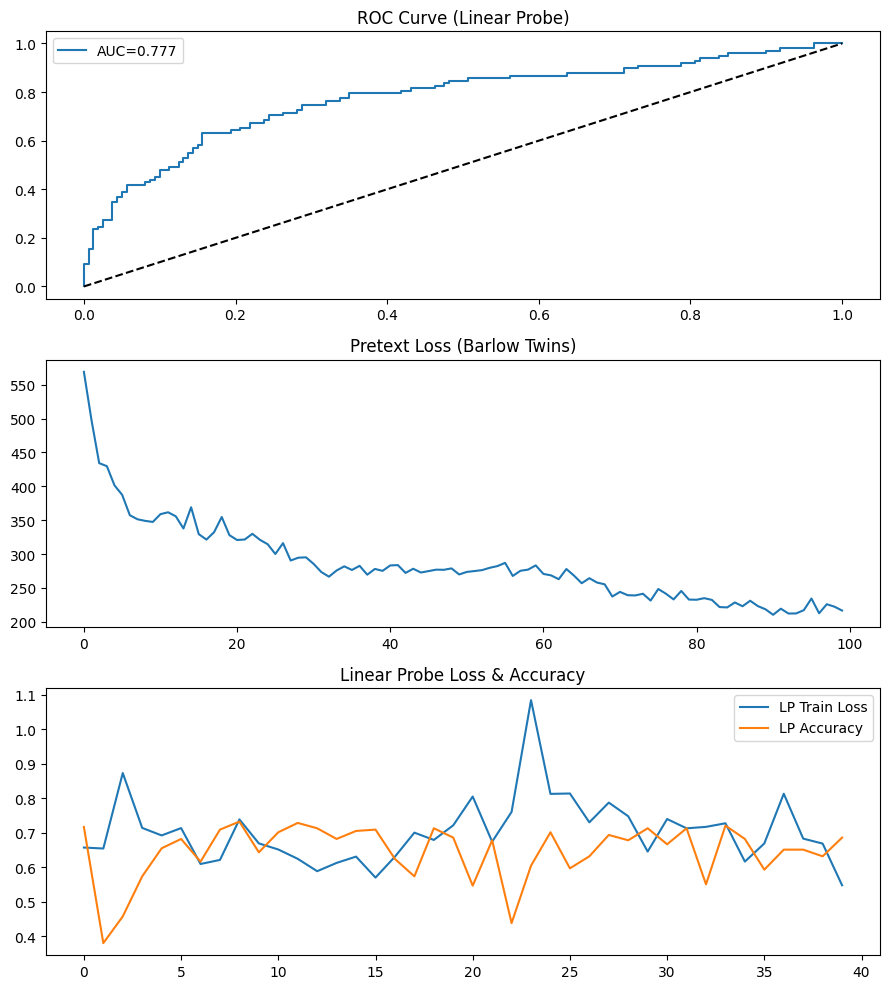

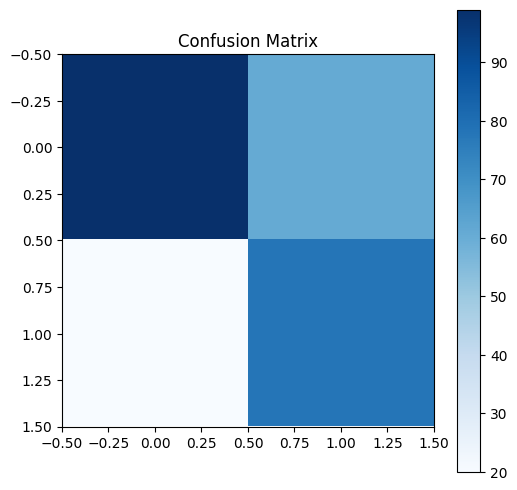

pretext_losses: [569.075986919981, 497.4149817264441, 434.24235765861744, 429.76052024147725, 401.3737876198509, 387.4017204515862, 357.36356515595406, 351.36770722360325, 349.0111777565696, 347.42972726532906, 358.93721424449575, 361.6751043146307, 355.7331311774976, 337.7657970081676, 369.1020785245028, 329.4337759306936, 321.3625377308239, 332.3324168812145, 354.706406102036, 327.9624735514323, 320.77866155450994, 321.49482680812025, 329.8887763745857, 320.9394022623698, 314.5221132220644, 300.0646787701231, 316.1243295380564, 290.4832782167377, 294.6239513050426, 295.1643672133937, 285.4698060931581, 273.490390661991, 266.5957410407789, 275.7890851569898, 281.84588160659325, 276.5063555168383, 282.66851113059306, 269.5462193344579, 278.05278061375475, 275.20121626420456, 283.225956772313, 283.68259314334756, 272.1580995501894, 278.3118068810665, 272.73221749970406, 274.854267467152, 276.96550542658025, 276.75227448434543, 278.85143025716144, 269.9135908647017, 273.64482995235556, 2

In [12]:
plt.figure(figsize=(9,10))

# ---------- ROC ----------
plt.subplot(3,1,1)
plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (Linear Probe)")
plt.legend()

# ---------- Pretext Loss ----------
plt.subplot(3,1,2)
plt.plot(pretext_losses)
plt.title("Pretext Loss (Barlow Twins)")

# ---------- Linear Probe ----------
plt.subplot(3,1,3)
plt.plot(lp_losses, label="LP Train Loss")
plt.plot(lp_accs, label="LP Accuracy")
plt.legend()
plt.title("Linear Probe Loss & Accuracy")

plt.tight_layout()

# SHOW and SAVE
plt.show()
plt.savefig("roc_and_losses.png")
plt.close()


# ---------- Confusion Matrix ----------
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

# SHOW and SAVE
plt.show()
plt.savefig("confusion_matrix.png")
plt.close()


print("pretext_losses:", pretext_losses)
print("len(pretext_losses):", len(pretext_losses))

print("lp_losses:", lp_losses)
print("lp_accs:", lp_accs)
print("LP epochs:", len(lp_losses))

print("ROC arrays:", fpr[:5], tpr[:5], auc_score)


# ============================================================
# Shallow Heads
# ============================================================

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Standardize features
sc = StandardScaler().fit(train_feats)
Xtr_s = sc.transform(train_feats)
Xte_s = sc.transform(test_feats)

models = {
    "MLP": MLPClassifier(hidden_layer_sizes=(256,), max_iter=300),
    "SVM_linear": SVC(kernel='linear'),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=200),
    "kNN_1": KNeighborsClassifier(1),
    "kNN_5": KNeighborsClassifier(5),
    "kNN_20": KNeighborsClassifier(20)
}

print("\n=== Shallow Heads ===")
for name, model in models.items():
    model.fit(Xtr_s, train_labels)
    acc = model.score(Xte_s, test_labels)
    print(f"{name} Accuracy = {acc:.4f}")



=== Shallow Heads ===
MLP Accuracy = 0.6899
SVM_linear Accuracy = 0.7248
DecisionTree Accuracy = 0.6860
RandomForest Accuracy = 0.7171
kNN_1 Accuracy = 0.6357
kNN_5 Accuracy = 0.6860
kNN_20 Accuracy = 0.7287


# ============================================================
# LABEL EFFICIENCY EXPERIMENTS
# ============================================================

In [14]:
print("\n=== Label Efficiency ===")
for frac in [0.01,0.05,0.1,0.25,0.5]:
    sss = StratifiedShuffleSplit(1, train_size=frac)
    idx, _ = next(sss.split(Xtr_s, train_labels))
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr_s[idx], train_labels[idx])
    print(f"{int(frac*100)}% labels → accuracy = {clf.score(Xte_s, test_labels):.4f}")


=== Label Efficiency ===
1% labels → accuracy = 0.6589
5% labels → accuracy = 0.5853
10% labels → accuracy = 0.6550
25% labels → accuracy = 0.6899
50% labels → accuracy = 0.6860



# ============================================================
# EMBEDDING ANALYSIS (PCA / TSNE / UMAP)
# ============================================================

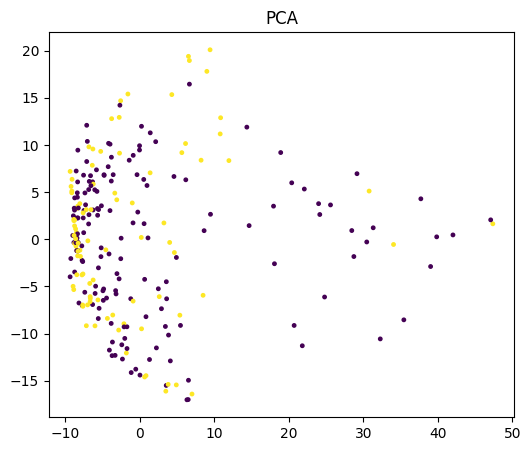

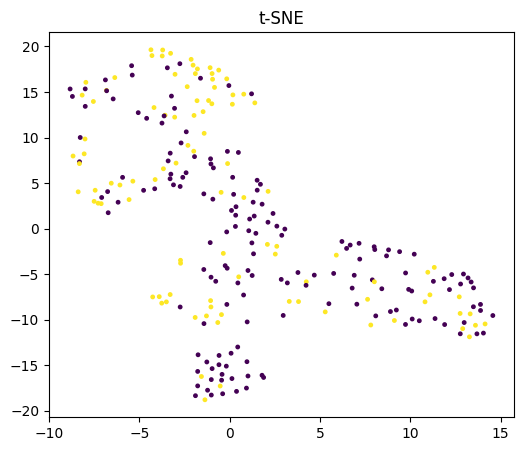

UMAP failed: check_array() got an unexpected keyword argument 'ensure_all_finite'
Silhouette score: 0.04741897


In [15]:
# PCA
pca2 = PCA(2).fit_transform(test_feats)
plt.figure(figsize=(6,5))
plt.scatter(pca2[:,0], pca2[:,1], c=test_labels, s=6)
plt.title("PCA")
plt.show()
plt.savefig("pca.png")
plt.close()

# t-SNE
tsne2 = TSNE(2).fit_transform(test_feats)
plt.figure(figsize=(6,5))
plt.scatter(tsne2[:,0], tsne2[:,1], c=test_labels, s=6)
plt.title("t-SNE")
plt.show()
plt.savefig("tsne.png")
plt.close()

# UMAP
if UMAP_OK:
    try:
        umap2 = umap.UMAP(n_components=2).fit_transform(test_feats)
        plt.figure(figsize=(6,5))
        plt.scatter(umap2[:,0], umap2[:,1], c=test_labels, s=6)
        plt.title("UMAP")
        plt.show()
        plt.savefig("umap.png")
        plt.close()
    except Exception as e:
        print("UMAP failed:", e)

# Silhouette
print("Silhouette score:", silhouette_score(test_feats, test_labels, metric='cosine'))


# ============================================================
# GFLOPs PROXY (FORWARD TIME MEASURE)
# ============================================================

In [16]:

dummy = torch.randn(1,3,IMAGE_SIZE,IMAGE_SIZE)
t0=time.time(); _=backbone(dummy); t1=time.time()
print("Forward time per sample:", t1-t0)

Forward time per sample: 0.047803640365600586



# ============================================================
# PRINT SUMMARY
# ============================================================

In [17]:
print("\n======== SUMMARY ========")
print("Linear Probe Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)
print("ROC AUC:", auc_score)
print("Shallow Heads:", models.keys())
print("==========================")


======== SUMMARY ========
Linear Probe Accuracy: 0.7286821705426356
Precision: 0.5611510791366906
Recall: 0.7959183673469388
F1: 0.6582278481012659
ROC AUC: 0.7769770408163266
Shallow Heads: dict_keys(['MLP', 'SVM_linear', 'DecisionTree', 'RandomForest', 'kNN_1', 'kNN_5', 'kNN_20'])
